see: https://huggingface.co/facebook/detr-resnet-50-panoptic

see: https://huggingface.co/facebook/detr-resnet-101-panoptic

Loading image from /Users/sueszli/dev/advx-bench/data/kodak/kodim22.png


Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


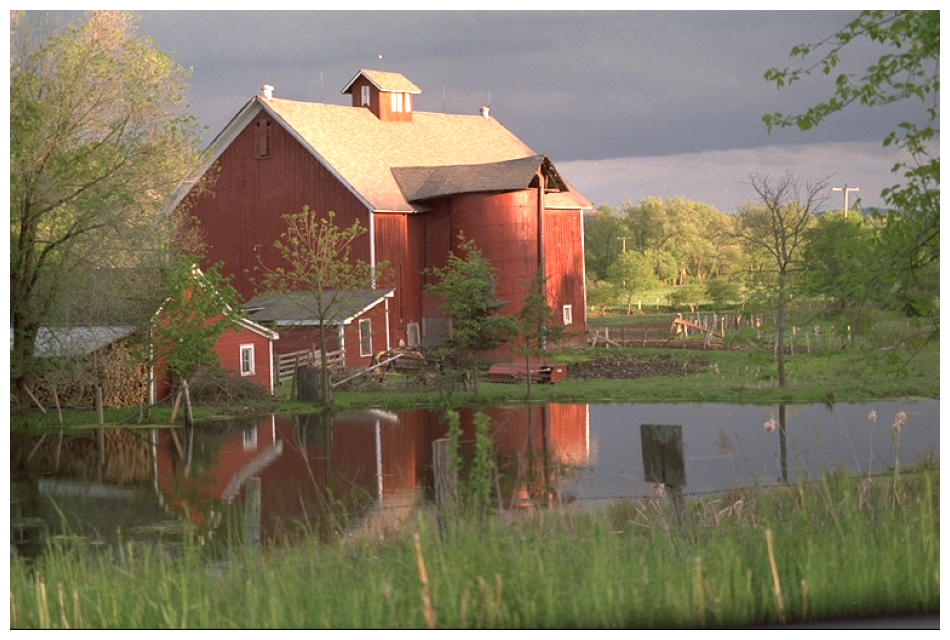

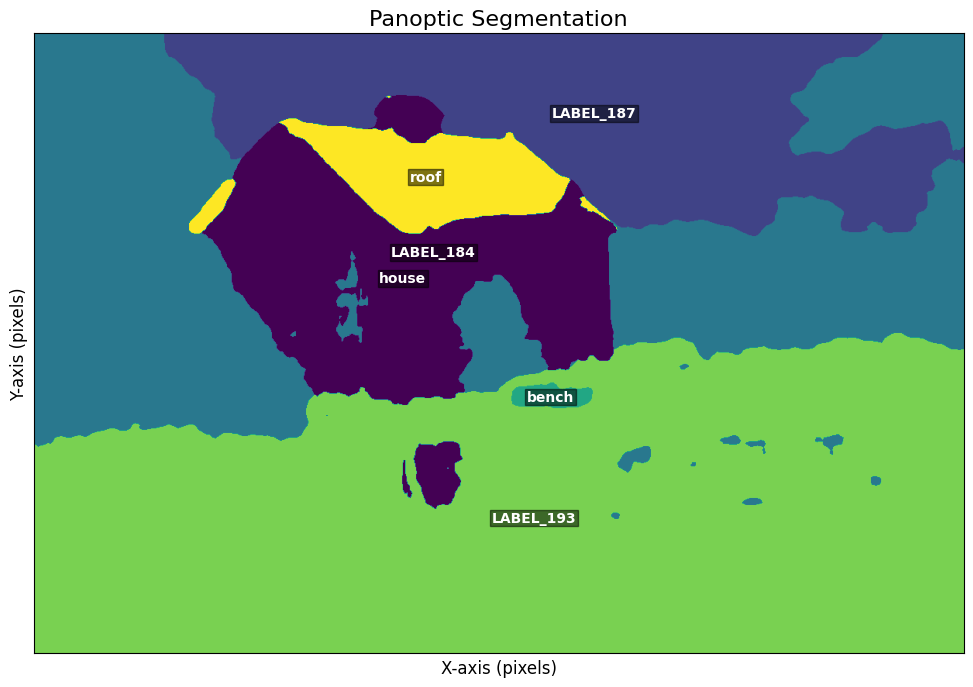

In [15]:
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image
import torch
import numpy
import numpy as np
from pathlib import Path
import random

from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id


"""
read in model
"""


filename =  f'kodim{random.randint(1, 24):02d}.png'
imgpath = Path.cwd().parent.parent / 'data' / 'kodak' / filename
print(f'Loading image from {imgpath}')
assert imgpath.exists(), f'Image not found at {imgpath}'
image = Image.open(imgpath)


# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)


"""
run model
"""


feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# use the `post_process_panoptic` method of `DetrFeatureExtractor` to convert to COCO format
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]

# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
# retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg)


"""
visualize image
"""


plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis("off")
plt.show()


"""
visualize panoptic segmentation
"""


# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# for elem in result["segments_info"]:
#     elem_id = elem["id"] # unique id of the mask
#     elem_name = model.config.id2label[elem["category_id"]] # name of the class (e.g. 'horse')
#     elem_area = elem["area"] # number of pixels of the mask in the image
#     print(f"Mask {elem_id} is a {elem_name} with area {elem_area}")

# ax.imshow(panoptic_seg_id)
# plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(panoptic_seg_id)
plt.title("Panoptic Segmentation", fontsize=16)

# add labels for each segment
for elem in result["segments_info"]:
    elem_id = elem["id"]
    elem_name = model.config.id2label[elem["category_id"]]
    elem_area = elem["area"]
    
    # Find the center of the segment
    y, x = np.where(panoptic_seg_id == elem_id)
    if len(x) > 0 and len(y) > 0:
        center_x, center_y = np.mean(x), np.mean(y)
        ax.annotate(elem_name, (center_x, center_y), color='white', fontweight='bold', ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, pad=1))

plt.xlabel("X-axis (pixels)", fontsize=12)
plt.ylabel("Y-axis (pixels)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.show()
